In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()

msNPC=spark.read.option("inferSchema","true").csv("Query + Visualization/MsNPC.csv",header=True)
msPlayer=spark.read.option("inferSchema","true").csv("Query + Visualization/MsPlayer.csv",header=True)
msWeapon=spark.read.option("inferSchema","true").csv("Query + Visualization/MsWeapon.csv",header=True)
msWeaponType=spark.read.option("inferSchema","true").csv("Query + Visualization/MsWeaponType.csv",header=True)
transactionHeader=spark.read.option("inferSchema","true").csv("Query + Visualization/TransactionHeader.csv",header=True)
transactionDetail=spark.read.option("inferSchema","true").csv("Query + Visualization/TransactionDetail.csv",header=True)

msNPC.registerTempTable("MsNPC")
msPlayer.registerTempTable("MsPlayer")
msWeapon.registerTempTable("MsWeapon")
msWeaponType.registerTempTable("MsWeaponType")
transactionHeader.registerTempTable("TransactionHeader")
transactionDetail.registerTempTable("TransactionDetail")




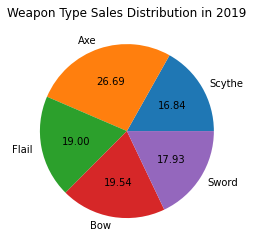

In [3]:
resl = spark.sql("""SELECT WeaponTypeName,SUM(WeaponPrice*Quantity) AS TotalSales
                    FROM MsWeaponType a
                    JOIN MsWeapon b on a.WeaponTypeId=b.WeaponTypeId
                    JOIN TransactionDetail c on c.WeaponId=b.WeaponId
                    JOIN TransactionHeader d on d.TransactionId=c.TransactionId
                    WHERE YEAR(TransactionDate)=2019
                    GROUP BY b.WeaponTypeID, WeaponTypeName""")

resl=resl.toPandas()
plt.title("Weapon Type Sales Distribution in 2019")
plt.pie(resl['TotalSales'],labels=resl['WeaponTypeName'],autopct="%.2f")
plt.show()

Text(0.5, 1.0, 'Axe Buyer in 2019 statistics')

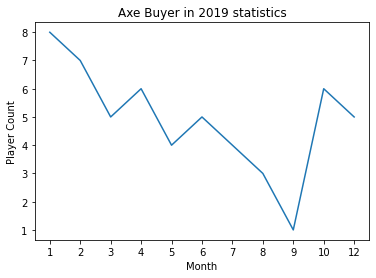

In [4]:
res2=spark.sql("""SELECT MONTH(TransactionDate) AS Month, Count(DISTINCT PlayerId) AS PlayerCount
                  FROM MsWeaponType a
                  JOIN MsWeapon b on a.WeaponTypeId=b.WeaponTypeId
                  JOIN TransactionDetail c on c.WeaponId=b.WeaponId
                  JOIN TransactionHeader d on d.TransactionId=c.TransactionId
                  WHERE WeaponTypeName='Axe' AND YEAR(TransactionDate)=2019
                  GROUP BY Month
                  ORDER BY Month ASC""")

t1=["January","Febuary","March","April","Mei","Juny"]

res2=res2.toPandas()
plt.plot(res2['PlayerCount'])
plt.xticks(range(len(res2['Month'])),res2['Month'])
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.title("Axe Buyer in 2019 statistics")

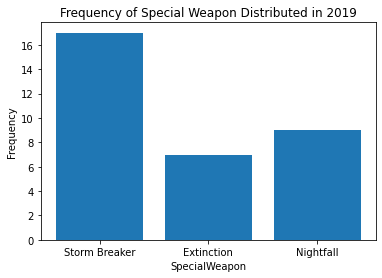

In [13]:
res3= spark.sql(""" SELECT x.SpecialWeapon,COUNT(x.PlayerID) AS Frequency FROM(
                        SELECT MONTH(TransactionDate) AS Month,e.PlayerId, SUM(WeaponPrice*Quantity) AS Spending,
                        CASE
                            WHEN SUM(WeaponPrice*Quantity)>=2000000 THEN 'Extinction'
                            WHEN SUM(WeaponPrice*Quantity)>=1500000 THEN 'Nightfall'
                            WHEN SUM(WeaponPrice*Quantity)>=1000000 THEN 'Storm Breaker'
                        END AS SpecialWeapon
                        FROM MsWeapon b 
                        JOIN TransactionDetail c on c.WeaponId=b.WeaponId
                        JOIN TransactionHeader d on d.TransactionId=c.TransactionId
                        JOIN MsPlayer e ON e.PlayerId=d.PlayerId
                        WHERE PlayerGender='Female' AND YEAR(TransactionDate) = 2019
                        GROUP BY Month ,e.PlayerId
                    ) AS x
                    WHERE x.SpecialWeapon !='null'
                    GROUP BY x.SpecialWeapon""")

# res3.show()

res3=res3.toPandas()
plt.bar(res3['SpecialWeapon'],res3['Frequency'])
plt.xlabel('SpecialWeapon')
plt.ylabel('Frequency')
plt.title("Frequency of Special Weapon Distributed in 2019")
plt.show()

+-----+-----------+
|Month|PlayerCount|
+-----+-----------+
|    1|          6|
|    2|          5|
|    3|          4|
|    4|          3|
|    5|          3|
|    6|          3|
|    7|          5|
|    8|          2|
|    9|          1|
|   10|          5|
|   11|          2|
|   12|          5|
+-----+-----------+



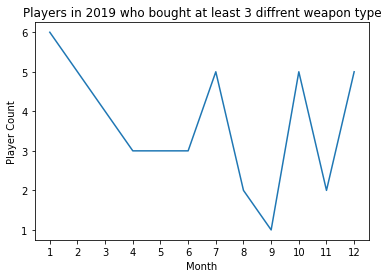

In [29]:
res4=spark.sql("""  SELECT x.Month,COUNT(*) AS PlayerCount FROM(
                        SELECT d.PlayerId,MONTH(TransactionDate) AS Month,COUNT(DISTINCT WeaponTypeId) AS WeaponTypeCount
                        FROM MsWeapon b 
                        JOIN TransactionDetail c on c.WeaponId=b.WeaponId
                        JOIN TransactionHeader d on d.TransactionId=c.TransactionId
                        WHERE YEAR(TransactionDate)=2019
                        GROUP BY d.PlayerId,Month
                        HAVING WeaponTypeCount>=3
                    )AS x
                    GROUP BY x.Month
                    ORDER BY x.Month ASC""")

res4.show()

res4=res4.toPandas()

plt.plot(res4['PlayerCount'])
plt.xticks(range(len(res4['Month'])),res4['Month'])
plt.xlabel("Month")
plt.ylabel("Player Count")
plt.title("Players in 2019 who bought at least 3 diffrent weapon type")
plt.show()

+-------------+---------+
|   Popularity|Frequency|
+-------------+---------+
|Quite Popular|        2|
|      Popular|        8|
| Very Popular|        2|
+-------------+---------+



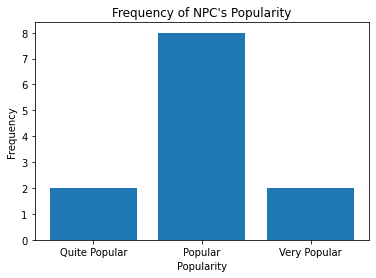

In [38]:
res5=spark.sql("""  SELECT x.Popularity,COUNT(x.NPCId) AS Frequency FROM(
                        SELECT a.NPCId ,COUNT(DISTINCT b.PlayerId) AS NumberOfPlayer, SUM(c.Quantity*d.WeaponPrice) AS Income,
                        CASE
                            WHEN SUM(c.Quantity*d.WeaponPrice)>=15000000 THEN 'Very Popular'
                            WHEN SUM(c.Quantity*d.WeaponPrice)>=7500000 THEN 'Popular'
                            WHEN SUM(c.Quantity*d.WeaponPrice)>=2500000  THEN 'Quite Popular'
                            ELSE 'Not Popular'
                        END AS Popularity
                        FROM MsNPC a
                        JOIN TransactionHeader b on a.NPCId=b.NPCId
                        JOIN TransactionDetail c on c.TransactionId=b.TransactionId
                        JOIN MsWeapon d on d.WeaponId=c.WeaponId
                        GROUP BY a.NPCId
                        HAVING NumberOfPlayer>=5
                    ) AS x
                    GROUP BY x.Popularity""")

res5.show()

res5= res5.toPandas()
plt.bar(res5['Popularity'],res5['Frequency'])
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.title("Frequency of NPC's Popularity")
plt.show()
